In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tqdm import tqdm

def load_and_preprocess_data(sar_dir, label_dir):
    """
    Load and preprocess SAR and label images based on the reference implementation
    """
    # Get list of files
    sar_files = sorted([f for f in os.listdir(sar_dir) if f.endswith(('.tif', '.png', '.jpg'))])
    label_files = sorted([f for f in os.listdir(label_dir) if f.endswith(('.tif', '.png', '.jpg'))])
    
    image_dataset = []
    mask_dataset = []
    
    print("Loading and preprocessing images...")
    for sar_file, label_file in tqdm(zip(sar_files, label_files)):
        # Load SAR image
        sar_path = os.path.join(sar_dir, sar_file)
        image = cv2.imread(sar_path, -1)  # -1 for unchanged mode
        
        # Load label image
        label_path = os.path.join(label_dir, label_file)
        mask = cv2.imread(label_path, -1)
        
        # Verify images were loaded successfully and have correct size
        if image is None or mask is None:
            print(f"Warning: Could not load {sar_file} or {label_file}")
            continue
            
        if image.shape[:2] != (128, 128) or mask.shape[:2] != (128, 128):
            print(f"Warning: Unexpected image size in {sar_file} or {label_file}")
            continue
        
        # Ensure SAR image is single channel
        if len(image.shape) > 2:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Add to datasets
        image_dataset.append(image)
        mask_dataset.append(mask)
    
    # Convert to numpy arrays
    image_dataset = np.array(image_dataset)
    mask_dataset = np.array(mask_dataset)
    
    
    print(f"\nLoaded {len(image_dataset)} image pairs successfully")
    print(f"SAR array shape: {image_dataset.shape}")
    print(f"Label array shape: {mask_dataset.shape}")

    
    return image_dataset, mask_dataset

# Usage example:
image_dataset, mask_dataset = load_and_preprocess_data(
     sar_dir='/kaggle/input/sample-data-openearthmap/sar_sample (1)',
     label_dir='/kaggle/input/sample-data-openearthmap/label_sample (1)'
 )

Loading and preprocessing images...


5000it [01:22, 60.86it/s]


Loaded 5000 image pairs successfully
SAR array shape: (5000, 128, 128)
Label array shape: (5000, 128, 128)


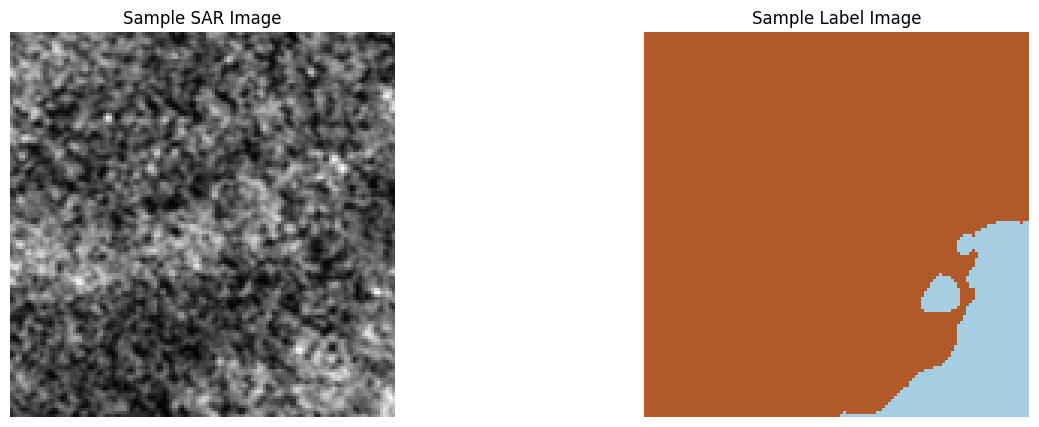

In [2]:
# Display sample images
index = np.random.randint(1080, len(image_dataset))
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_dataset[index].squeeze(), cmap='gray')
plt.title('Sample SAR Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(mask_dataset[index], cmap='Paired')
plt.title('Sample Label Image')
plt.axis('off')
plt.show()

In [3]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [4]:
def merge_classes(mask_image):
    mask_image_copy = mask_image.copy()

    # Define mapping based on merging rules
    merge_class_map = {
        2: 1, 
        4: 3, 
        7: 1,  
        8: 3
    }

    # Apply the merging
    for original_class, new_class in merge_class_map.items():
        mask_image_copy[np.where(mask_image_copy == original_class)] = new_class

    # Define final relabeling to align with target_class_dict
    final_relabel_map = {
        1: 0,  # Bareland
        3: 1,  # Builtup
        5: 2,  # Tree
        6: 3,  # Water
    }

    # Apply the final relabeling
    for original_label, new_label in final_relabel_map.items():
        mask_image_copy[np.where(mask_image_copy == original_label)] = new_label

    return mask_image_copy


In [5]:
labels_dataset = []
for i in range(mask_dataset.shape[0]):
        merged_mask = merge_classes(mask_dataset[i])
        labels_dataset.append(merged_mask)
labels_dataset = np.array(labels_dataset)
print(f"Labels shape:", labels_dataset.shape)

Labels shape: (5000, 128, 128)


In [6]:
#before_Bareland2 = len(np.where(mask_dataset.flatten()==0)[0])
before_Bareland = len(np.where(mask_dataset.flatten()==1)[0])
before_Rangland =   len(np.where(mask_dataset.flatten()==2)[0])
before_Developed_Space =   len(np.where(mask_dataset.flatten()==3)[0])
before_Road =   len(np.where(mask_dataset.flatten()==4)[0])
before_Tree =   len(np.where(mask_dataset.flatten()==5)[0])
before_Water =   len(np.where(mask_dataset.flatten()==6)[0])
before_Agriculture_Land =   len(np.where(mask_dataset.flatten()==7)[0])
before_Building =   len(np.where(mask_dataset.flatten()==8)[0])

after_Water =   len(np.where(labels_dataset.flatten()==3)[0])
after_Tree =   len(np.where(labels_dataset.flatten()==2)[0])
after_Bareland =   len(np.where(labels_dataset.flatten()==0)[0])
after_Builtup =   len(np.where(labels_dataset.flatten()==1)[0])

assert (before_Road+before_Building+before_Developed_Space) == after_Builtup, "Builtup does not match"
assert (before_Rangland+before_Bareland+before_Agriculture_Land) == after_Bareland, "Bareland does not match"
assert before_Tree == after_Tree, "Trees does not match"
assert before_Water == after_Water, "Water does not match"
print(' Merge Validation Passed')
print(' Water = ', np.round(after_Water/(labels_dataset.flatten().shape[0]), 3),
                        ' Trees = ', np.round(after_Tree/(labels_dataset.flatten().shape[0]), 3),
                        ' Bareland = ', np.round(after_Bareland/(labels_dataset.flatten().shape[0]), 3),
                        ' Builtup = ', np.round(after_Builtup/(labels_dataset.flatten().shape[0]), 3))

 Merge Validation Passed
 Water =  0.107  Trees =  0.14  Bareland =  0.336  Builtup =  0.417


In [7]:
n_classes = 4

In [8]:
X = image_dataset.reshape(-1, 128, 128, 1)
y = tf.keras.utils.to_categorical(labels_dataset, num_classes=4)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
from tensorflow.keras.models import load_model
model_pspnet = load_model("/kaggle/input/psp_openearth_sar/keras/default/1/pspnet_openearth_sar.keras")

In [11]:
model_unet = load_model("/kaggle/input/psp_openearth_sar/keras/default/1/unet_openearth_sar.keras")

In [12]:

predictions1 = model_pspnet.predict(X_val)
y_pred1 = np.argmax(predictions1, axis=-1).flatten()
predictions2 = model_unet.predict(X_val)
y_pred2 = np.argmax(predictions2, axis=-1).flatten()


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step


In [14]:
y_true = np.argmax(y_val, axis=-1).flatten()

In [23]:
accuracy1 = np.mean(y_pred1 == y_true)
print(accuracy1)
accuracy2 = np.mean(y_pred2 == y_true)
print(accuracy2)

0.6135996704101563
0.58429248046875


In [21]:
print(y_true.size)
print(y_pred1.size)
print(y_pred2.size)

16384000
16384000
16384000


In [19]:
from scipy import stats
import numpy as np

def mcnemar_test(y_true, pred_model1, pred_model2):
    """
    Perform McNemar's test between two models
    
    Args:
        y_true: Ground truth labels
        pred_model1: Predictions from first model
        pred_model2: Predictions from second model
    """
    # Get correct/incorrect predictions for each model
    correct_model1 = (pred_model1 == y_true)
    correct_model2 = (pred_model2 == y_true)
    
    # Calculate contingency table values
    b = np.sum(~correct_model1 & correct_model2)  # Model 1 wrong, Model 2 right
    c = np.sum(correct_model1 & ~correct_model2)  # Model 1 right, Model 2 wrong
    
    # Calculate McNemar's test statistic
    statistic = (abs(b - c) - 1)**2 / (b + c)
    
    # Calculate p-value
    p_value = stats.chi2.sf(statistic, df=1)
    
    # Print results
    print("\n=== McNemar's Test Results ===")
    print(f"Number of cases where Model 1 is wrong and Model 2 is right: {b}")
    print(f"Number of cases where Model 1 is right and Model 2 is wrong: {c}")
    print(f"Test statistic: {statistic:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Significant difference between models: {'Yes' if p_value < 0.05 else 'No'}")
    
    # Return statistics
    return statistic, p_value

In [24]:
statistic, p_value = mcnemar_test(y_true, y_pred1, y_pred2)


=== McNemar's Test Results ===
Number of cases where Model 1 is wrong and Model 2 is right: 1414409
Number of cases where Model 1 is right and Model 2 is wrong: 1894578
Test statistic: 69677.3086
p-value: 0.0000
Significant difference between models: Yes
